# Notebook used  to experiment with different models

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from sklearn.metrics import  mean_pinball_loss

In [61]:
#!pip install pmdarima

In [62]:
df = pd.read_csv("../traces/traces_persona.csv",parse_dates=[0])
diff = [df["reconsile_dates"][i] - df["reconsile_dates"][i-1] for i in range(1,len(df["reconsile_dates"]))]
diff_df = pd.DataFrame({"diff": diff, "sec": [x.total_seconds() for x in diff]}) 

endtrain  =  int(len(diff_df) * 0.8)
startTestIndex = endtrain
endtestIndex =  len(diff_df)-1

train_data = diff_df["sec"][:endtrain]
test_data = diff_df["sec"][endtrain:]

In [63]:
print(endtestIndex)

999


In [64]:
df,diff_df


(                      reconsile_dates
 0    2023-01-17 13:45:57.861000+00:00
 1    2023-01-17 13:46:00.918000+00:00
 2    2023-01-17 13:46:05.918000+00:00
 3    2023-01-17 13:46:11.046000+00:00
 4    2023-01-17 13:46:16.173000+00:00
 ...                               ...
 996  2023-01-17 15:12:21.972000+00:00
 997  2023-01-17 15:12:27.178000+00:00
 998  2023-01-17 15:12:32.338000+00:00
 999  2023-01-17 15:12:37.529000+00:00
 1000 2023-01-17 15:12:42.682000+00:00
 
 [1001 rows x 1 columns],
                       diff    sec
 0   0 days 00:00:03.057000  3.057
 1          0 days 00:00:05  5.000
 2   0 days 00:00:05.128000  5.128
 3   0 days 00:00:05.127000  5.127
 4   0 days 00:00:05.144000  5.144
 ..                     ...    ...
 995 0 days 00:00:05.180000  5.180
 996 0 days 00:00:05.206000  5.206
 997 0 days 00:00:05.160000  5.160
 998 0 days 00:00:05.191000  5.191
 999 0 days 00:00:05.153000  5.153
 
 [1000 rows x 2 columns])

In [65]:
df.describe(),diff_df.describe()

/tmp/ipykernel_7583/1579199578.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(),diff_df.describe()


(                         reconsile_dates
 count                               1001
 unique                              1001
 top     2023-01-17 13:45:57.861000+00:00
 freq                                   1
 first   2023-01-17 13:45:57.861000+00:00
 last    2023-01-17 15:12:42.682000+00:00,
                             diff          sec
 count                       1000  1000.000000
 mean      0 days 00:00:05.204821     5.204821
 std    0 days 00:00:00.611235877     0.611236
 min       0 days 00:00:00.206000     0.206000
 25%       0 days 00:00:05.168750     5.168750
 50%       0 days 00:00:05.198000     5.198000
 75%       0 days 00:00:05.230000     5.230000
 max       0 days 00:00:21.442000    21.442000)

In [66]:
df_stationarityTest = adfuller(df['reconsile_dates'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.0


In [67]:
a = df['reconsile_dates'][1]- df['reconsile_dates'][0]
a.microseconds

57000

/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


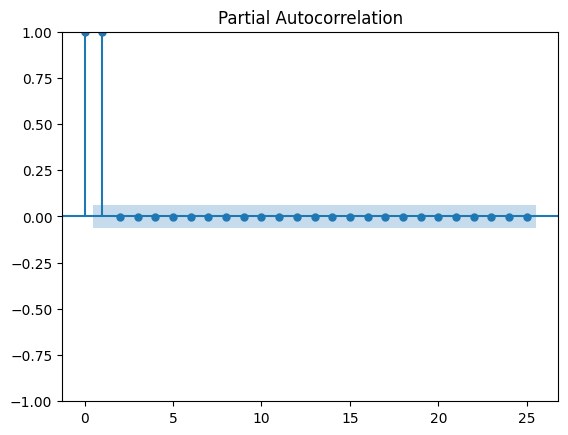

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['reconsile_dates'], lags=25)

# only use 2 long wide interval?

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2d07b87340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2d07b87880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2d07b870a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2d07b87dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2d07bac0a0>],
 'means': []}

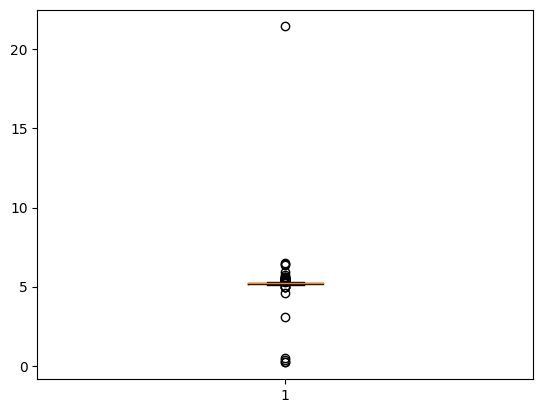

In [69]:
plt.boxplot([diff_df["sec"]])

(array([  2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   4., 480., 443.,  47.,   9.,   5.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

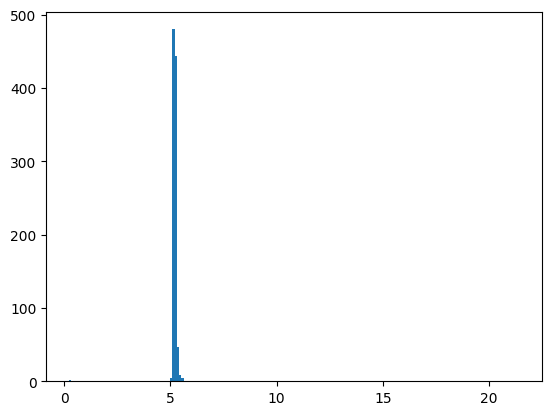

In [70]:
plt.hist(diff_df["sec"],bins=200)

# choosing loss function

In [71]:
# as defined in the scikit-learn  docs
# sklearn.metrics.mean_pinball_loss
def pinball_loss(y_true,y_pred, alpha):
    diff = y_true - y_pred
    sign = int(diff >= 0)
    loss = alpha * sign  * diff - (1 - alpha) * (1 - sign) * diff
    return loss

def total_perside_piball_loss(y_true_array,y_pred_array, alpha=0.25):
    assert len(y_pred_array) == len(y_true_array)
    underEstimate = []
    overEstimate = []
    totalEstimate = []
    for y_true,y_pred in zip(y_true_array,y_pred_array):

        diff = y_true - y_pred
        sign = int(diff >= 0)
        
        score = pinball_loss(y_true=y_true, y_pred=y_pred,alpha=alpha)
        
        if sign == 0:
            overEstimate.append(score)
        else:
            underEstimate.append(score)
        totalEstimate.append(score)
    
    underEstimate_score = np.mean(underEstimate)
    overEstimate_score = np.mean(overEstimate)
    ##print(totalEstimate)
    total_score = np.mean(totalEstimate)
    
    print(f"there are {len(underEstimate)} underEstimates with mean {underEstimate_score} ")
    print(f"there are {len(overEstimate)} overEstimates with mean {overEstimate_score}")
    print(f"total mean absolute pinball score {total_score}")
    return (underEstimate_score,overEstimate_score,total_score)

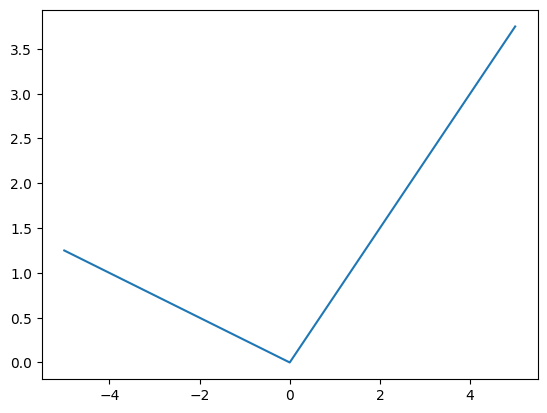

In [72]:
alpha = 0.25 
x = np.concatenate([np.arange(-5,0,0.1), np.arange(0,5.1,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
plt.plot(x,y)


In [73]:
pinball_loss(0,5.2117485916887-5.136,0.25)

0.056811443766524805

In [74]:
pinball_loss(0,1,0.25)

0.75

## auto regression

In [75]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

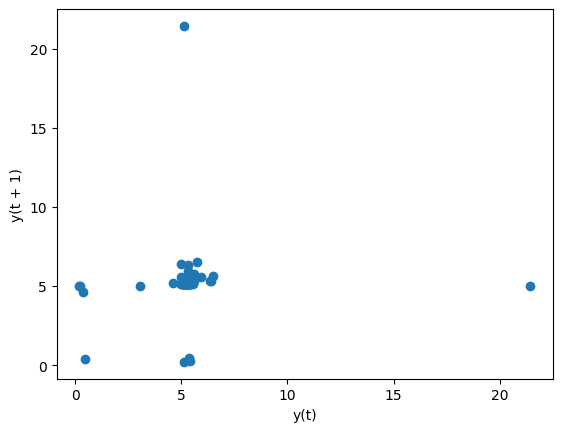

In [76]:
lag_plot(diff_df["sec"])

not really a lot of corrolation, no real line  visable

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

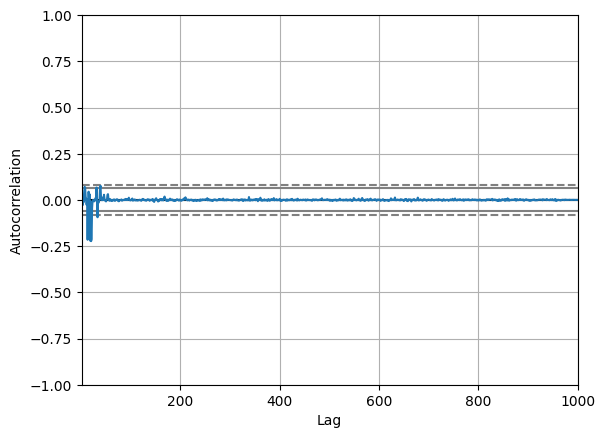

In [77]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_df["sec"])

as expected, since the times are constant, no real big  swings, by adding more lag, we don't gain anything 

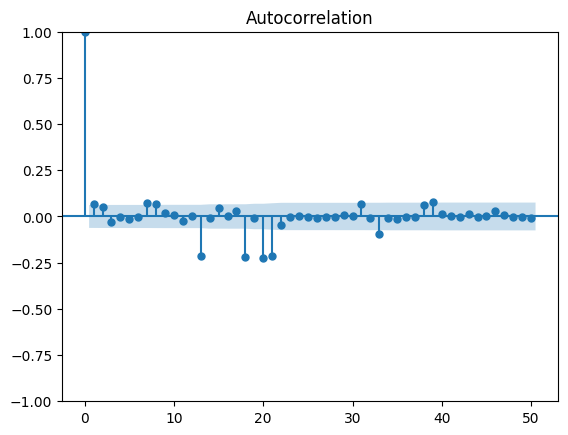

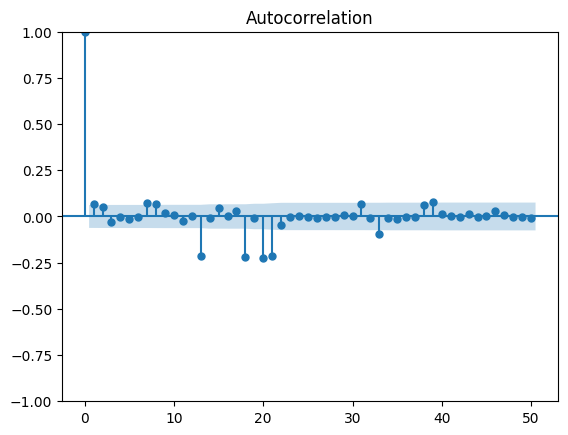

In [78]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff_df["sec"], lags=50)

after 25 we see only small differences

In [79]:
model = AutoReg(train_data, lags=10).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    sec   No. Observations:                  800
Model:                    AutoReg(10)   Log Likelihood                -812.571
Method:               Conditional MLE   S.D. of innovations              0.677
Date:                Wed, 15 Mar 2023   AIC                           1649.141
Time:                        10:57:48   BIC                           1705.205
Sample:                            10   HQIC                          1670.691
                                  800                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2236      0.527      8.013      0.000       3.190       5.257
sec.L1         0.0605      0.036      1.701      0.089      -0.009       0.130
sec.L2         0.0527      0.036      1.478      0.1

In [80]:
pred = model.predict(start=startTestIndex, end=endtestIndex, dynamic=False)

In [81]:
print(test_data)

800    5.203
801    5.223
802    5.224
803    5.136
804    5.284
       ...  
995    5.180
996    5.206
997    5.160
998    5.191
999    5.153
Name: sec, Length: 200, dtype: float64


/tmp/ipykernel_7583/1787682364.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


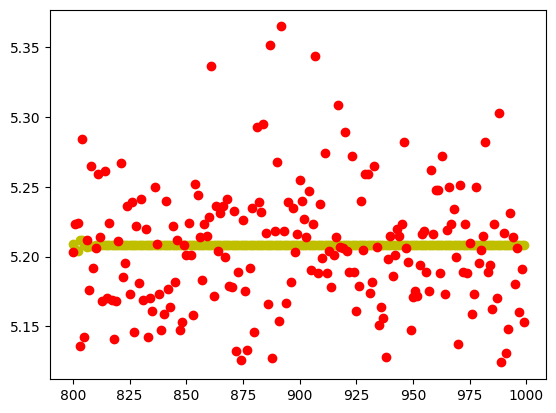

In [82]:

plt.plot(pred,'yo')
plt.plot(test_data,'yo', color='red')

In [83]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 93 underEstimates with mean 0.00886419801756572 
there are 107 overEstimates with mean 0.024683173504844783
total mean absolute pinball score 0.017327349903260018


(0.00886419801756572, 0.024683173504844783, 0.017327349903260018)

In [84]:
mean_pinball_loss(test_data,pred,alpha=0.25)

0.017327349903260018

In [85]:
(93*0.00886090487541144 + 106 * 0.024891221882406035)/199

0.01739966669823268

In [86]:
difference = test_data - pred


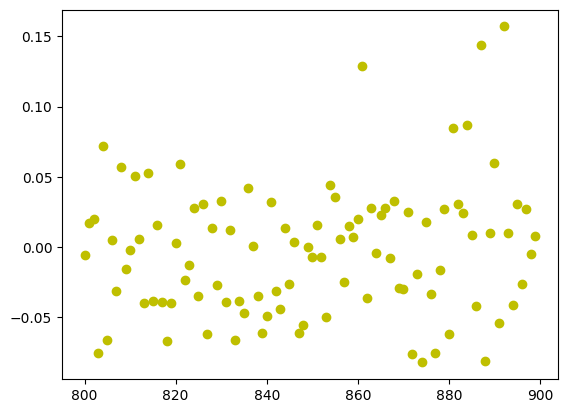

In [87]:
plt.plot(difference[0:100],"yo")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2d076b36d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2d076b3b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2d076b3430>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2d076e8100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2d076e83a0>],
 'means': []}

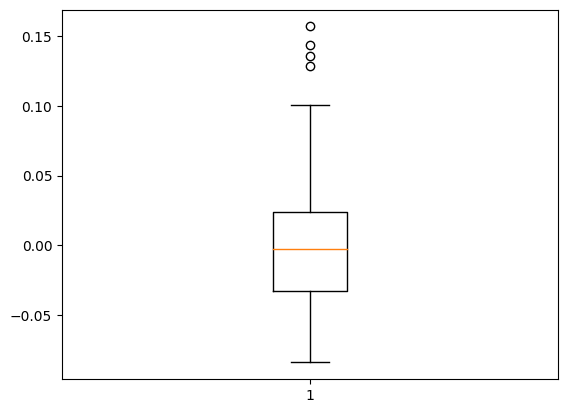

In [88]:
plt.boxplot(difference)

instead of predicting all test results at a time, do 1 by 1 and relearn like  our framework can do

In [89]:

pred = []
for i in range(startTestIndex,len(diff_df)):
    model = AutoReg(diff_df["sec"][:i], lags=10).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])

    

In [90]:
len(diff_df)

1000

In [91]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 92 underEstimates with mean 0.009244003971309079 
there are 108 overEstimates with mean 0.024898724841082527
total mean absolute pinball score 0.017697553240986735


(0.009244003971309079, 0.024898724841082527, 0.017697553240986735)

as expected  we do not  see a lot of improvement

# arima

In [92]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [93]:
adf,pval,_,_,_,_ = adfuller(diff_df["sec"])
print(f"p value {pval} < 0.05 => stationairy")

p value 1.7417236011374657e-24 < 0.05 => stationairy


choose what arima model

In [94]:
model = pm.auto_arima(diff_df["sec"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6152.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2472.050, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5069.922, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1853.852, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1856.332, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1853.352, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1854.101, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1855.204, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1854.695, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1856.101, Time=0.76 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 3.894 seconds


In [95]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -922.676
Date:                Wed, 15 Mar 2023   AIC                           1853.352
Time:                        10:57:56   BIC                           1872.983
Sample:                             0   HQIC                          1860.813
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6063      0.265     17.362      0.000       4.086       5.126
ar.L1          0.0643      0.013      4.988      0.000       0.039       0.090
ar.L2          0.0506      0.048      1.048      0.295      -0.044       0.145
sigma2         0.3706      0.002    232.902      0.000       0.368       0.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          11316047.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            16.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
from statsmodels.tsa.arima.model import ARIMA

In [97]:
model = ARIMA(train_data, order=(2, 0, 0))

In [98]:
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -826.978
Date:                Wed, 15 Mar 2023   AIC                           1661.956
Time:                        10:57:56   BIC                           1680.695
Sample:                             0   HQIC                          1669.155
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2039      0.042    124.055      0.000       5.122       5.286
ar.L1          0.0641      0.016      3.975      0.000       0.033       0.096
ar.L2          0.0501      0.059      0.843      0.399      -0.066       0.167
sigma2         0.4628      0.002    186.321      0.000       0.458       0.468
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           5808909.57
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            15.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       419.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

/tmp/ipykernel_7583/999615282.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


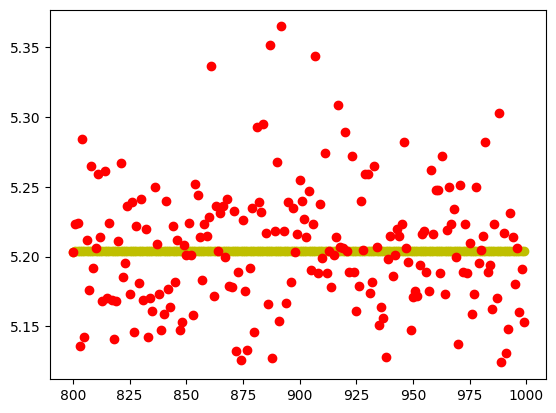

In [100]:
plt.plot(pred,'yo')
plt.plot(test_data,'yo', color='red')

In [101]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 105 underEstimates with mean 0.008824387377224399 
there are 95 overEstimates with mean 0.024399480096544468
total mean absolute pinball score 0.016222556418901433


(0.008824387377224399, 0.024399480096544468, 0.016222556418901433)

In [102]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ARIMA(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])

In [103]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 99 underEstimates with mean 0.00932542573735128 
there are 101 overEstimates with mean 0.023602233898079396
total mean absolute pinball score 0.01653521385851898


(0.00932542573735128, 0.023602233898079396, 0.01653521385851898)

# sarima

our data is  not really  seasonal so  skip this

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [105]:
model = SARIMAX(train_data, order=(2, 0, 0))

In [106]:
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20922D+00    |proj g|=  4.57167D-03

At iterate    5    f=  1.20922D+00    |proj g|=  7.02219D-04

At iterate   10    f=  1.20921D+00    |proj g|=  6.23692D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.237D-06   1.209D+00
  F =   1.2092059222922071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -967.365
Date:                Wed, 15 Mar 2023   AIC                           1940.729
Time:                        10:58:16   BIC                           1954.783
Sample:                             0   HQIC                          1946.128
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5034      0.004    128.429      0.000       0.496       0.511
ar.L2          0.4882      0.005    105.484      0.000       0.479       0.497
sigma2         0.6541      0.003    210.780      0.000       0.648       0.660
===================================================================================
Ljung-Box (L1) (Q):                  13.49   Jarque-Bera (JB):           1804531.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             7.67
Prob(H) (two-sided):                  0.00   Kurtosis:                       235.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

/tmp/ipykernel_7583/999615282.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


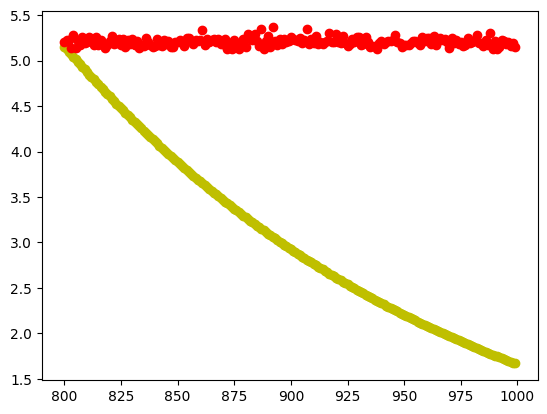

In [108]:
plt.plot(pred,'yo')
plt.plot(test_data,'yo', color='red')

In [109]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 200 underEstimates with mean 0.5281108210663504 
there are 0 overEstimates with mean nan
total mean absolute pinball score 0.5281108210663504


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.5281108210663504, nan, 0.5281108210663504)

predicting that far into the future is pritty bad

In [110]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = SARIMAX(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20922D+00    |proj g|=  4.57167D-03

At iterate    5    f=  1.20922D+00    |proj g|=  7.02219D-04

At iterate   10    f=  1.20921D+00    |proj g|=  6.23692D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.237D-06   1.209D+00
  F =   1.2092059222922071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20735D+00    |proj g|=  4.58752D-03

At iterate    5    f=  1.20735D+00    |proj g|=  7.00564D-04

At iterate   10    f=  1.20733D+00    |proj g|=  6.55664D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.557D-06   1.207D+00
  F =   1.2073343639498222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20672D+00    |proj g|=  6.98547D-04

At iterate   10    f=  1.20671D+00    |proj g|=  6.39564D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.396D-06   1.207D+00
  F =   1.2067108336386125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20613D+00    |proj g|=  4.59778D-03

At iterate    5    f=  1.20612D+00    |proj g|=  6.99349D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20550D+00    |proj g|=  4.60521D-03

At iterate    5    f=  1.20550D+00    |proj g|=  6.97527D-04

At iterate   10    f=  1.20548D+00    |proj g|=  6.63538D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.635D-06   1.205D+00
  F =   1.2054840383213097     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20487D+00    |proj g|=  6.96819D-04

At iterate   10    f=  1.20486D+00    |proj g|=  6.71476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.715D-06   1.205D+00
  F =   1.2048628426747079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20426D+00    |proj g|=  4.61642D-03

At iterate    5    f=  1.20425D+00    |proj g|=  6.96013D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.20302D+00    |proj g|=  6.95069D-04

At iterate   10    f=  1.20301D+00    |proj g|=  7.06184D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.062D-06   1.203D+00
  F =   1.2030128245299858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20241D+00    |proj g|=  4.63245D-03

At iterate    5    f=  1.20240D+00    |proj g|=  6.93984D-04

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20118D+00    |proj g|=  6.93008D-04

At iterate   10    f=  1.20117D+00    |proj g|=  7.36589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.366D-06   1.201D+00
  F =   1.2011664877833150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20057D+00    |proj g|=  4.64981D-03

At iterate    5    f=  1.20056D+00    |proj g|=  6.91216D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19934D+00    |proj g|=  6.89954D-04

At iterate   10    f=  1.19933D+00    |proj g|=  7.48936D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.489D-06   1.199D+00
  F =   1.1993287124945660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19873D+00    |proj g|=  4.66527D-03

At iterate    5    f=  1.19873D+00    |proj g|=  6.89325D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19812D+00    |proj g|=  4.67161D-03

At iterate    5    f=  1.19811D+00    |proj g|=  6.88043D-04

At iterate   10    f=  1.19810D+00    |proj g|=  7.60385D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.604D-06   1.198D+00
  F =   1.1981015567493896     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10



 This problem is unconstrained.



At iterate    5    f=  1.19750D+00    |proj g|=  6.86414D-04

At iterate   10    f=  1.19749D+00    |proj g|=  7.52443D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.524D-06   1.197D+00
  F =   1.1974878499177601     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19690D+00    |proj g|=  4.68381D-03

At iterate    5    f=  1.19689D+00    |proj g|=  6.85776D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19629D+00    |proj g|=  4.68778D-03

At iterate    5    f=  1.19629D+00    |proj g|=  6.85782D-04

At iterate   10    f=  1.19627D+00    |proj g|=  7.90970D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.910D-06   1.196D+00
  F =   1.1962746722100521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.19569D+00    |proj g|=  6.86114D-04

At iterate   10    f=  1.19568D+00    |proj g|=  8.24674D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.247D-06   1.196D+00
  F =   1.1956767681254108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19508D+00    |proj g|=  4.69809D-03

At iterate    5    f=  1.19508D+00    |proj g|=  6.84426D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19447D+00    |proj g|=  4.70442D-03

At iterate    5    f=  1.19447D+00    |proj g|=  6.83143D-04

At iterate   10    f=  1.19446D+00    |proj g|=  8.16056D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.161D-06   1.194D+00
  F =   1.1944560768332404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19387D+00    |proj g|=  6.82984D-04

At iterate   10    f=  1.19385D+00    |proj g|=  8.40374D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.404D-06   1.194D+00
  F =   1.1938541683822625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19326D+00    |proj g|=  4.71530D-03

At iterate    5    f=  1.19326D+00    |proj g|=  6.81467D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19266D+00    |proj g|=  4.71974D-03

At iterate    5    f=  1.19265D+00    |proj g|=  6.81147D-04

At iterate   10    f=  1.19264D+00    |proj g|=  8.56994D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.570D-06   1.193D+00
  F =   1.1926433818904500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19085D+00    |proj g|=  4.73703D-03

At iterate    5    f=  1.19084D+00    |proj g|=  6.77969D-04

At iterate   10    f=  1.19083D+00    |proj g|=  8.74947D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.749D-06   1.191D+00
  F =   1.1908308896504169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19024D+00    |proj g|=  6.77723D-04

At iterate   10    f=  1.19023D+00    |proj g|=  8.98546D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.985D-06   1.190D+00
  F =   1.1902323691213899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18965D+00    |proj g|=  4.74796D-03

At iterate    5    f=  1.18964D+00    |proj g|=  6.76152D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18905D+00    |proj g|=  4.75295D-03

At iterate    5    f=  1.18904D+00    |proj g|=  6.75535D-04

At iterate   10    f=  1.18903D+00    |proj g|=  9.09768D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.098D-06   1.189D+00
  F =   1.1890278412535353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18844D+00    |proj g|=  6.73778D-04

At iterate   10    f=  1.18843D+00    |proj g|=  9.01741D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.017D-06   1.188D+00
  F =   1.1884251899625242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18784D+00    |proj g|=  4.76555D-03

At iterate    5    f=  1.18784D+00    |proj g|=  6.72740D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18724D+00    |proj g|=  4.77091D-03

At iterate    5    f=  1.18724D+00    |proj g|=  6.71876D-04

At iterate   10    f=  1.18722D+00    |proj g|=  9.20461D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.205D-06   1.187D+00
  F =   1.1872248482035441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18605D+00    |proj g|=  6.71391D-04

At iterate   10    f=  1.18604D+00    |proj g|=  9.73277D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.733D-06   1.186D+00
  F =   1.1860415099513086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18546D+00    |proj g|=  4.78626D-03

At iterate    5    f=  1.18545D+00    |proj g|=  6.69618D-04


 This problem is unconstrained.



At iterate   10    f=  1.18544D+00    |proj g|=  9.63742D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.637D-06   1.185D+00
  F =   1.1854425441671268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18486D+00    |proj g|=  4.79288D-03

At iterate    5    f=  1.18486D+00    |proj g|=  6.68004D-04

At iterate   10    f=  1.18484D+00    |proj g|=  9.59093D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18427D+00    |proj g|=  4.79834D-03

At iterate    5    f=  1.18426D+00    |proj g|=  6.67057D-04

At iterate   10    f=  1.18425D+00    |proj g|=  9.69878D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   9.699D-06   1.184D+00
  F =   1.1842479637596517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.18367D+00    |proj g|=  1.01313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.098D-07   1.184D+00
  F =   1.1836666587637021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18309D+00    |proj g|=  4.80735D-03


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18308D+00    |proj g|=  6.66143D-04

At iterate   10    f=  1.18307D+00    |proj g|=  1.01589D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.112D-07   1.183D+00
  F =   1.1830706844694923     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18249D+00    |proj g|=  4.81395D-03

At iterate    5    f=  1.18249D+00    |proj g|=  6.64532D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18191D+00    |proj g|=  4.81790D-03

At iterate    5    f=  1.18190D+00    |proj g|=  6.64397D-04

At iterate   10    f=  1.18189D+00    |proj g|=  1.04236D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.152D-07   1.182D+00
  F =   1.1818884609078388     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18131D+00    |proj g|=  6.63257D-04

At iterate   10    f=  1.18130D+00    |proj g|=  1.04969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.167D-07   1.181D+00
  F =   1.1812951422841256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18072D+00    |proj g|=  4.82874D-03

At iterate    5    f=  1.18072D+00    |proj g|=  6.62459D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18013D+00    |proj g|=  4.83547D-03

At iterate    5    f=  1.18012D+00    |proj g|=  6.60685D-04

At iterate   10    f=  1.18011D+00    |proj g|=  1.05848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.198D-07   1.180D+00
  F =   1.1801115310810462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17837D+00    |proj g|=  4.85022D-03

At iterate    5    f=  1.17836D+00    |proj g|=  6.58597D-04

At iterate   10    f=  1.17835D+00    |proj g|=  1.11653D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.268D-07   1.178D+00
  F =   1.1783505585258542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17661D+00    |proj g|=  4.86756D-03

At iterate    5    f=  1.17660D+00    |proj g|=  6.54934D-04

At iterate   10    f=  1.17659D+00    |proj g|=  1.13638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.317D-07   1.177D+00
  F =   1.1765872370900967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.17602D+00    |proj g|=  6.55116D-04

At iterate   10    f=  1.17601D+00    |proj g|=  1.18033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.353D-07   1.176D+00
  F =   1.1760116914395073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17545D+00    |proj g|=  4.87517D-03

At iterate    5    f=  1.17544D+00    |proj g|=  6.54730D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17486D+00    |proj g|=  4.88143D-03

At iterate    5    f=  1.17486D+00    |proj g|=  6.53195D-04

At iterate   10    f=  1.17484D+00    |proj g|=  1.20988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.394D-07   1.175D+00
  F =   1.1748440185120868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.17427D+00    |proj g|=  6.51464D-04

At iterate   10    f=  1.17426D+00    |proj g|=  1.20411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.405D-07   1.174D+00
  F =   1.1742582051014114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17370D+00    |proj g|=  4.89263D-03

At iterate    5    f=  1.17369D+00    |proj g|=  6.50874D-04


 This problem is unconstrained.



At iterate   10    f=  1.17368D+00    |proj g|=  1.22901D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.430D-07   1.174D+00
  F =   1.1736771642162354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17311D+00    |proj g|=  4.89768D-03

At iterate    5    f=  1.17311D+00    |proj g|=  6.50043D-04

At iterate   10    f=  1.17310D+00    |proj g|=  1.24856D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.477D-07   1.173D+00
  F =   1.1725139312516120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17197D+00    |proj g|=  4.90469D-03

At iterate    5    f=  1.17197D+00    |proj g|=  6.50065D-04

At iterate   10    f=  1.17195D+00    |proj g|=  1.33612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.17080D+00    |proj g|=  1.30579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.533D-07   1.171D+00
  F =   1.1707951834715966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17023D+00    |proj g|=  4.92382D-03

At iterate    5    f=  1.17023D+00    |proj g|=  6.44936D-04

At iterate   10    f=  1.17022D+00    |proj g|=  1.32066D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16907D+00    |proj g|=  6.43366D-04

At iterate   10    f=  1.16906D+00    |proj g|=  1.36621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.604D-07   1.169D+00
  F =   1.1690614023205135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16850D+00    |proj g|=  4.93982D-03

At iterate    5    f=  1.16849D+00    |proj g|=  6.41784D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16735D+00    |proj g|=  4.95084D-03

At iterate    5    f=  1.16734D+00    |proj g|=  6.39400D-04

At iterate   10    f=  1.16733D+00    |proj g|=  1.38909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.653D-07   1.167D+00
  F =   1.1673301703654304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.16619D+00    |proj g|=  1.43308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.702D-07   1.166D+00
  F =   1.1661853485281879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16563D+00    |proj g|=  4.96789D-03

At iterate    5    f=  1.16562D+00    |proj g|=  6.35422D-04

At iterate   10    f=  1.16561D+00    |proj g|=  1.41294D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.16446D+00    |proj g|=  1.43243D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.741D-07   1.164D+00
  F =   1.1644633954091461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16392D+00    |proj g|=  4.98239D-03

At iterate    5    f=  1.16391D+00    |proj g|=  6.32932D-04

At iterate   10    f=  1.16390D+00    |proj g|=  1.48381D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16277D+00    |proj g|=  6.29675D-04

At iterate   10    f=  1.16276D+00    |proj g|=  1.48302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.805D-07   1.163D+00
  F =   1.1627575083163904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16221D+00    |proj g|=  4.99894D-03

At iterate    5    f=  1.16220D+00    |proj g|=  6.29223D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16107D+00    |proj g|=  6.27127D-04

At iterate   10    f=  1.16106D+00    |proj g|=  1.55755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.879D-07   1.161D+00
  F =   1.1610625761994531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16053D+00    |proj g|=  5.01133D-03

At iterate    5    f=  1.16052D+00    |proj g|=  6.27781D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15939D+00    |proj g|=  6.25367D-04

At iterate   10    f=  1.15938D+00    |proj g|=  1.66218D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.967D-07   1.159D+00
  F =   1.1593778080918919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15884D+00    |proj g|=  5.02581D-03

At iterate    5    f=  1.15883D+00    |proj g|=  6.25295D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15770D+00    |proj g|=  6.20874D-04

At iterate   10    f=  1.15769D+00    |proj g|=  1.67770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.014D-07   1.158D+00
  F =   1.1576878846266665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15718D+00    |proj g|=  5.04002D-03

At iterate    5    f=  1.15717D+00    |proj g|=  6.22509D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15605D+00    |proj g|=  6.17792D-04

At iterate   10    f=  1.15604D+00    |proj g|=  1.74039D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.079D-07   1.156D+00
  F =   1.1560389476365609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15551D+00    |proj g|=  5.05659D-03

At iterate    5    f=  1.15550D+00    |proj g|=  6.18280D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15494D+00    |proj g|=  6.15659D-04

At iterate   10    f=  1.15493D+00    |proj g|=  1.78370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.123D-07   1.155D+00
  F =   1.1549309859206300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15442D+00    |proj g|=  5.06427D-03

At iterate    5    f=  1.15442D+00    |proj g|=  6.17172D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15330D+00    |proj g|=  6.12248D-04

At iterate   10    f=  1.15329D+00    |proj g|=  1.83929D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.184D-07   1.153D+00
  F =   1.1532872077280290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15275D+00    |proj g|=  5.08276D-03

At iterate    5    f=  1.15274D+00    |proj g|=  6.11937D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15164D+00    |proj g|=  5.09297D-03

At iterate    5    f=  1.15163D+00    |proj g|=  6.09761D-04

At iterate   10    f=  1.15162D+00    |proj g|=  1.93640D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.261D-07   1.152D+00
  F =   1.1516177024686223     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14997D+00    |proj g|=  5.10746D-03

At iterate    5    f=  1.14996D+00    |proj g|=  6.07017D-04

At iterate   10    f=  1.14995D+00    |proj g|=  2.02928D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.336D-07   1.150D+00
  F =   1.1499516592213122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.378D-07   1.149D+00
  F =   1.1488401210875343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14830D+00    |proj g|=  5.12384D-03

At iterate    5    f=  1.14830D+00    |proj g|=  6.03066D-04

At iterate   10    f=  1.14828D+00    |proj g|=  2.07732D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.14718D+00    |proj g|=  2.11647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.433D-07   1.147D+00
  F =   1.1471787191222458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14664D+00    |proj g|=  5.13940D-03

At iterate    5    f=  1.14664D+00    |proj g|=  5.99528D-04

At iterate   10    f=  1.14663D+00    |proj g|=  2.14486D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14556D+00    |proj g|=  5.97931D-04

At iterate   10    f=  1.14555D+00    |proj g|=  2.22230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.507D-07   1.146D+00
  F =   1.1455528652807498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14502D+00    |proj g|=  5.15378D-03

At iterate    5    f=  1.14501D+00    |proj g|=  5.96431D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14392D+00    |proj g|=  5.94842D-04

At iterate   10    f=  1.14391D+00    |proj g|=  2.31228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.574D-07   1.144D+00
  F =   1.1439072167596189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14337D+00    |proj g|=  5.16916D-03

At iterate    5    f=  1.14337D+00    |proj g|=  5.90637D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14227D+00    |proj g|=  5.87679D-04

At iterate   10    f=  1.14226D+00    |proj g|=  2.37156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.650D-07   1.142D+00
  F =   1.1422584514459533     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14173D+00    |proj g|=  5.18533D-03

At iterate    5    f=  1.14172D+00    |proj g|=  5.88891D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14065D+00    |proj g|=  5.88718D-04

At iterate   10    f=  1.14064D+00    |proj g|=  2.50889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.705D-07   1.141D+00
  F =   1.1406390618011992     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14011D+00    |proj g|=  5.19848D-03

At iterate    5    f=  1.14010D+00    |proj g|=  5.86605D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.13955D+00    |proj g|=  2.48278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.726D-07   1.140D+00
  F =   1.1395464792364969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13903D+00    |proj g|=  5.20763D-03

At iterate    5    f=  1.13903D+00    |proj g|=  5.84903D-04

At iterate   10    f=  1.13901D+00    |proj g|=  2.57624D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.13794D+00    |proj g|=  5.80904D-04

At iterate   10    f=  1.13793D+00    |proj g|=  2.55427D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.783D-07   1.138D+00
  F =   1.1379256934850572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13741D+00    |proj g|=  5.22329D-03

At iterate    5    f=  1.13740D+00    |proj g|=  5.81035D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.13632D+00    |proj g|=  5.76868D-04

At iterate   10    f=  1.13631D+00    |proj g|=  2.61387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.835D-07   1.136D+00
  F =   1.1363092087896982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13579D+00    |proj g|=  5.24116D-03

At iterate    5    f=  1.13578D+00    |proj g|=  5.75774D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13472D+00    |proj g|=  5.24953D-03

At iterate    5    f=  1.13471D+00    |proj g|=  5.74518D-04

At iterate   10    f=  1.13470D+00    |proj g|=  2.76113D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.904D-07   1.135D+00
  F =   1.1346985300811965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.13363D+00    |proj g|=  2.87880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.951D-07   1.134D+00
  F =   1.1336277905406376     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13311D+00    |proj g|=  5.26502D-03

At iterate    5    f=  1.13310D+00    |proj g|=  5.70685D-04

At iterate   10    f=  1.13309D+00    |proj g|=  2.83658D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.13204D+00    |proj g|=  5.69302D-04

At iterate   10    f=  1.13203D+00    |proj g|=  2.94704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.997D-07   1.132D+00
  F =   1.1320289880393317     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13151D+00    |proj g|=  5.27902D-03

At iterate    5    f=  1.13150D+00    |proj g|=  5.67819D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13044D+00    |proj g|=  5.29152D-03

At iterate    5    f=  1.13043D+00    |proj g|=  5.63864D-04

At iterate   10    f=  1.13042D+00    |proj g|=  2.94229D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.031D-07   1.130D+00
  F =   1.1304214928842695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.060D-07   1.129D+00
  F =   1.1293519456650229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12884D+00    |proj g|=  5.30590D-03

At iterate    5    f=  1.12884D+00    |proj g|=  5.60690D-04

At iterate   10    f=  1.12883D+00    |proj g|=  3.06096D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.12778D+00    |proj g|=  5.58854D-04

At iterate   10    f=  1.12777D+00    |proj g|=  3.15643D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.121D-07   1.128D+00
  F =   1.1277660969360455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12725D+00    |proj g|=  5.32010D-03

At iterate    5    f=  1.12724D+00    |proj g|=  5.57689D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.12619D+00    |proj g|=  5.55849D-04

At iterate   10    f=  1.12618D+00    |proj g|=  3.29188D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.167D-07   1.126D+00
  F =   1.1261761942407442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12566D+00    |proj g|=  5.33411D-03

At iterate    5    f=  1.12566D+00    |proj g|=  5.54771D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12461D+00    |proj g|=  5.34351D-03

At iterate    5    f=  1.12461D+00    |proj g|=  5.52682D-04

At iterate   10    f=  1.12460D+00    |proj g|=  3.42153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.210D-07   1.125D+00
  F =   1.1245958859110630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.12354D+00    |proj g|=  3.39463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.226D-07   1.124D+00
  F =   1.1235379249031689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12303D+00    |proj g|=  5.36093D-03

At iterate    5    f=  1.12302D+00    |proj g|=  5.47526D-04

At iterate   10    f=  1.12301D+00    |proj g|=  3.43069D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.12197D+00    |proj g|=  5.45388D-04

At iterate   10    f=  1.12196D+00    |proj g|=  3.51901D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.263D-07   1.122D+00
  F =   1.1219597367777356     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12145D+00    |proj g|=  5.37492D-03

At iterate    5    f=  1.12145D+00    |proj g|=  5.44556D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.12091D+00    |proj g|=  3.64824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.286D-07   1.121D+00
  F =   1.1209147019454850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12041D+00    |proj g|=  5.38365D-03

At iterate    5    f=  1.12040D+00    |proj g|=  5.42938D-04

At iterate   10    f=  1.12039D+00    |proj g|=  3.70068D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11935D+00    |proj g|=  5.39665D-04

At iterate   10    f=  1.11934D+00    |proj g|=  3.71847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.315D-07   1.119D+00
  F =   1.1193421816051170     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11885D+00    |proj g|=  5.39766D-03

At iterate    5    f=  1.11884D+00    |proj g|=  5.39817D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11780D+00    |proj g|=  5.37582D-04

At iterate   10    f=  1.11779D+00    |proj g|=  3.92964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.340D-07   1.118D+00
  F =   1.1177881905977334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11729D+00    |proj g|=  5.41187D-03

At iterate    5    f=  1.11728D+00    |proj g|=  5.36660D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11624D+00    |proj g|=  5.34253D-04

At iterate   10    f=  1.11623D+00    |proj g|=  4.06309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.355D-07   1.116D+00
  F =   1.1162340681818095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11573D+00    |proj g|=  5.42793D-03

At iterate    5    f=  1.11572D+00    |proj g|=  5.32061D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11470D+00    |proj g|=  5.43637D-03

At iterate    5    f=  1.11469D+00    |proj g|=  5.30605D-04

At iterate   10    f=  1.11468D+00    |proj g|=  4.17908D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.369D-07   1.115D+00
  F =   1.1146830146910651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.11365D+00    |proj g|=  4.24630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.373D-07   1.114D+00
  F =   1.1136472212192661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11315D+00    |proj g|=  5.45211D-03

At iterate    5    f=  1.11314D+00    |proj g|=  5.26370D-04

At iterate   10    f=  1.11313D+00    |proj g|=  4.25527D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11212D+00    |proj g|=  5.24106D-04

At iterate   10    f=  1.11211D+00    |proj g|=  4.34191D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.379D-07   1.112D+00
  F =   1.1121103558892458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11161D+00    |proj g|=  5.46655D-03

At iterate    5    f=  1.11160D+00    |proj g|=  5.22802D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11058D+00    |proj g|=  5.47664D-03

At iterate    5    f=  1.11058D+00    |proj g|=  5.20221D-04

At iterate   10    f=  1.11057D+00    |proj g|=  4.44406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.378D-07   1.111D+00
  F =   1.1105656128712917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.10954D+00    |proj g|=  4.48691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.378D-07   1.110D+00
  F =   1.1095382576388133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10904D+00    |proj g|=  5.49236D-03

At iterate    5    f=  1.10904D+00    |proj g|=  5.15946D-04

At iterate   10    f=  1.10903D+00    |proj g|=  4.51644D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10803D+00    |proj g|=  5.50028D-03

At iterate    5    f=  1.10802D+00    |proj g|=  5.14686D-04

At iterate   10    f=  1.10801D+00    |proj g|=  4.68072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.356D-07   1.108D+00
  F =   1.1080133355430184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.10699D+00    |proj g|=  4.76523D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.342D-07   1.107D+00
  F =   1.1069924290616564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10651D+00    |proj g|=  5.51292D-03

At iterate    5    f=  1.10650D+00    |proj g|=  5.12355D-04

At iterate   10    f=  1.10649D+00    |proj g|=  4.89685D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10548D+00    |proj g|=  5.08351D-04

At iterate   10    f=  1.10547D+00    |proj g|=  4.86013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.325D-07   1.105D+00
  F =   1.1054724347656439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10498D+00    |proj g|=  5.53062D-03

At iterate    5    f=  1.10497D+00    |proj g|=  5.06706D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10397D+00    |proj g|=  5.53964D-03

At iterate    5    f=  1.10396D+00    |proj g|=  5.04726D-04

At iterate   10    f=  1.10395D+00    |proj g|=  4.97890D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.293D-07   1.104D+00
  F =   1.1039518754869879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10



 This problem is unconstrained.



At iterate   10    f=  1.10296D+00    |proj g|=  5.05361D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.271D-07   1.103D+00
  F =   1.1029615913725928     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10247D+00    |proj g|=  5.55330D-03

At iterate    5    f=  1.10247D+00    |proj g|=  5.01250D-04

At iterate   10    f=  1.10246D+00    |proj g|=  5.10397D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10145D+00    |proj g|=  4.97842D-04

At iterate   10    f=  1.10144D+00    |proj g|=  5.10801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.246D-07   1.101D+00
  F =   1.1014440298614319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10097D+00    |proj g|=  5.56691D-03

At iterate    5    f=  1.10096D+00    |proj g|=  4.98165D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09997D+00    |proj g|=  5.57701D-03

At iterate    5    f=  1.09996D+00    |proj g|=  4.95522D-04

At iterate   10    f=  1.09995D+00    |proj g|=  5.32361D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.166D-07   1.100D+00
  F =   1.0999480068396243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09894D+00    |proj g|=  5.37780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   6.135D-07   1.099D+00
  F =   1.0989426810874885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09846D+00    |proj g|=  5.59171D-03

At iterate    5    f=  1.09845D+00    |proj g|=  4.91787D-04

At iterate   10    f=  1.09844D+00    |proj g|=  5.42974D-05

       

In [111]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 171 underEstimates with mean 0.01828417405667318 
there are 29 overEstimates with mean 0.01960165803133733
total mean absolute pinball score 0.01847520923299948


(0.01828417405667318, 0.01960165803133733, 0.01847520923299948)

model predicts pritty good, underestimates more, which is better for our framework

/tmp/ipykernel_7583/3450318698.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(test_data,'yo', color='red')


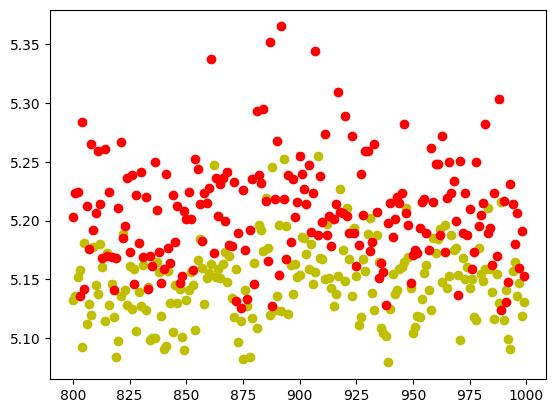

In [112]:

plt.plot(range(startTestIndex,len(diff_df)),pred,'yo')
plt.plot(test_data,'yo', color='red')

# Exponential smoothing

## simple  smoothing

In [113]:
from statsmodels.tsa.api import  SimpleExpSmoothing

In [114]:
model = SimpleExpSmoothing(train_data, initialization_method="estimated")

In [115]:
result = model.fit()

In [116]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

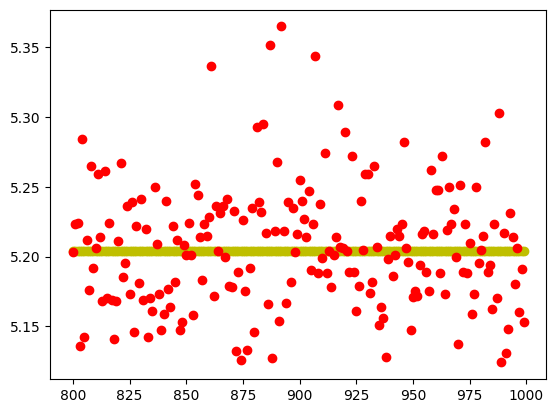

In [117]:
plt.plot(pred,'yo')
plt.plot(test_data,'o', color='red')

In [118]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [119]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    
    model = SimpleExpSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [120]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)

##  Holt

In [121]:
from statsmodels.tsa.api import  Holt

In [122]:
model = Holt(train_data, initialization_method="estimated")
result = model.fit()

In [123]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

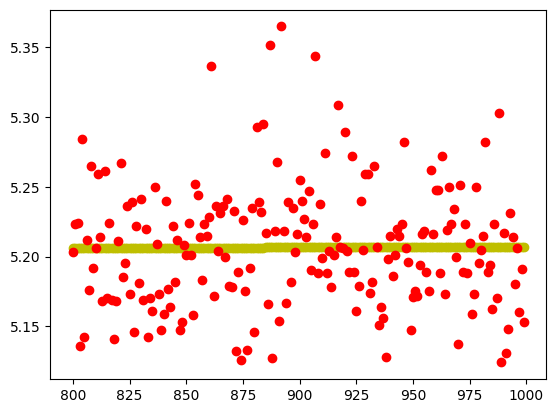

In [124]:
plt.plot(pred,'yo')
plt.plot(test_data,'o', color='red')

In [125]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 96 underEstimates with mean 0.008962064828373932 
there are 104 overEstimates with mean 0.02421011925209374
total mean absolute pinball score 0.01689105312870823


(0.008962064828373932, 0.02421011925209374, 0.01689105312870823)

In [126]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = Holt(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [127]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 94 underEstimates with mean 0.009150895870901716 
there are 106 overEstimates with mean 0.024045705963195156
total mean absolute pinball score 0.017045145219817242


(0.009150895870901716, 0.024045705963195156, 0.017045145219817242)

# holtz winter

In [128]:
from statsmodels.tsa.api import ExponentialSmoothing

In [129]:
model = ExponentialSmoothing(train_data, initialization_method="estimated")
result = model.fit()
pred =  result.predict(start=startTestIndex, end=endtestIndex)

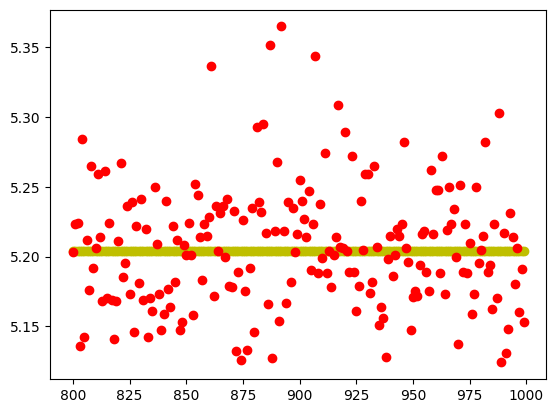

In [130]:
plt.plot(pred,'yo')
plt.plot(test_data,'o', color='red')

In [131]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [132]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ExponentialSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [133]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)